# **Multiclass Sentiment Analysis with pre-trained BERT model from Hugging Face to classify twitter tweets**


We used BERT for the SEMEVAL subtask A:  Message Polarity Classification. We build a multiclass classifier model that uses BERT embeddings to predict whether the tweet has a positive, negative, or neutral sentiment.

BERT, Bidirectional Encoder Representations from Transformers, introduced by Devlin et al.
(2019), belongs to the transformer-based, fairly new family of neural network architectures. It
uses multiple encoders, which are stacked upon each other, with attention to predict words and
sentences. We used the BERT model to get an enriched input representation: an embedding vector of size 768 for each of the text tokens. These representations are fed as input for the Message Polarity Classification.


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
     |████████████████████████████████| 61 kB 541 kB/s 
     |████████████████████████████████| 3.3 MB 39.8 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from tqdm.notebook import tqdm
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

datapath = '/content/data/semeval-2013-train.csv'
df = pd.read_csv(datapath, sep='\t')
#df = pd.read_csv('/content/data/semeval-2013-train-all.csv', sep='\t')
df.head()

#https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

label                                               text
0      0  Today's news: Democrats offer Republicans ever...
1      0  @stanscates I would use that in ads from now u...
2      0  Microsoft issues critical patch for Windows 7,...
3      0  will testdrive the new Nokia N9 phone with our...
4     -1  no way to underestimate the madness and cynici...

# **The Data**

This subtask is a rerun and provides data from previous years e.g., SemEval-2013 edition, which we used for training/development and primer testing. Source: https://www.kaggle.com/azzouza2018/semevaldatadets

A tweet, twitter text message, comes with a lable encoded as   

*   negative: -1 
*    positive: 1
*    neutral: 0 

We have the foollowing distribution in our less balanced training data: 


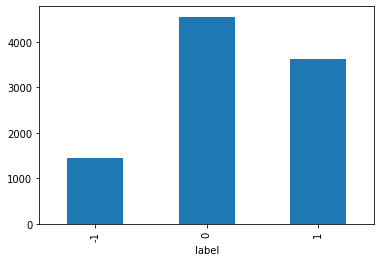

In [ ]:
df.groupby(['label']).size().plot.bar()

**CLEANING**

The longest tweet had more than 2000 characters in /content/data/semeval-2013-train.csv'. Therefore, to follow the twitter guidelines to only allow 280 characters we excluded all texts that had more than this amount of characters. This resulted only in a tiny reduction rom 9616 into 9614 total tweets in the dataset.

For a better representation, twitter user references are normalized as "@USER" and URLs as "@URL".

In [ ]:
df['len'] = [len(string) for string in df['text']] # number of characters per tweet
df = df.loc[df["len"] <= 280] 
#print(df.describe) only texts with les than 280 characters allowed

In [ ]:
import re

text_at_removed = [ re.sub("@[\S]*","@USER", text) for text in df['text']] # \S as any non-whitespace
text_link_removed = [ re.sub("http://[\S]*","@URL", text) for text in text_at_removed]
text_punctuation_sep = [ " ".join(re.findall(r"[\w'@]+|[.,!?;]", string)) for string in text_link_removed]

df['text'] = text_link_removed

print(df.describe)

<bound method NDFrame.describe of       label                                               text  len
0         0  Today's news: Democrats offer Republicans ever...  138
1         0  @USER I would use that in ads from now until O...  130
2         0  Microsoft issues critical patch for Windows 7,...  136
3         0  will testdrive the new Nokia N9 phone with our...   82
4        -1  no way to underestimate the madness and cynici...  126
...     ...                                                ...  ...
9611      0  envy everyone going to the Big Bang shows tomo...   68
9612      1  @USER Thank you. Now I just need to ace the th...   74
9613      0  Tiffany, CNBLUE's Yonghwa and B2ST's Kikwang M...  122
9614      1  @USER woosahhhh it's Courtney! Long time no se...   73
9615     -1  Slept for about 11 hours. I seem to be in quit...  136

[9614 rows x 3 columns]>


In [ ]:
df.sample(10)

label                                               text  len
7796      0          Anyone going to volleyball game tomorrow?   41
157       1  Finally wrapped up shooting in Vegas, time for...   74
9416     -1  on october 25 2011 I told taylor swift i would...  139
2378     -1  Depending on your sensibilities, Unofficially ...  138
3602      1  Are you all ready for Roger Sanchez this Frida...  125
2962      1  @USER I saw you at church Sunday with tohse Da...   83
8583      0  Flight with Denzel Washington comes out tomorr...   53
9580     -1  Spain summons Argentine ambassador in oil disp...  130
5609      1  Tomorrow, the Jimmy Donn Eastbound & Down" pre...  135
3599     -1  As an introduction to Literature we wrote abou...  135

# **Preprocessing Data for BERT**

We used a pre-trained BertTokenizer from bert-base-cased model, which worked best with the tweet texts in English. The uncased model might miss some IMPORTANT information encoded, This pre-trained tokenizer also brings the input into the correct BERT format with added [CLS], [SEP] and [PAD] tokens

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'This is an example tweet for doing the Multiclass Sentiment Analysis with twitter data'
bert_input = tokenizer(example_text,padding='max_length', max_length = 300, 
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids']) #  id representation of each token
example_tweet = tokenizer.decode(bert_input.input_ids[0])
print(example_text == example_tweet)
#print(bert_input['token_type_ids']) # not needed for classification
#print(bert_input['attention_mask']) # distinction whether token is just padding or not

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tensor([[  101,  1188,  1110,  1126,  1859,   189, 24887,  1111,  1833,  1103,
         18447,  1665, 17223, 14895,  4974,  2227, 12504,  1114,   189, 10073,
          8634,  2233,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

# **Dateset Split**

This Dataset class will serve as a class to generate the needed tweet datasets.
We split the data into training, validation, and test set with the proportion of 80:10:10. The data is transformed into the shape expected by the BERT model. The plots below showcase that the distribution of sentiments is not balanced, though we took notion to have the same representation in all our created sub-datasets (train/dev/test).

In [ ]:
labels = {'negative':0,
          'positive':1,
          'neutral':2,
          } # map the category into the id representation of label

def to_sentiment(numb):
    ''' convert numeric representation into string'''
    if numb==-1:
        return "negative"
    elif numb:
        return "positive"
    else:
        return "neutral"

#df['y'] = df.label.replace(labels)
#replacing numbers (-1,0,1) with text_label
df["y"] = df.label.apply(to_sentiment)

class Dataset(torch.utils.data.Dataset):
     #defining dataset class: split dataframe into training, validation, 
     #and test set with the proportion 80:10:10

    def __init__(self, df):

        self.labels = [labels[label] for label in df['y']] #mapping
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 300, truncation=True,
                                return_tensors="pt") for text in df['text']]
                                #max len 512, which is the maximum length of a sequence allowed for BERT.

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112) # always the same randomness :)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

7691 961 962


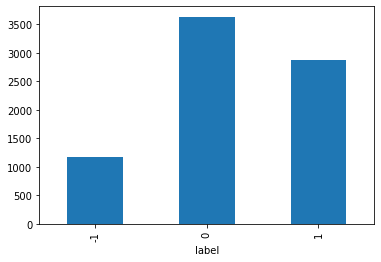

In [ ]:
df_train.groupby(['label']).size().plot.bar()

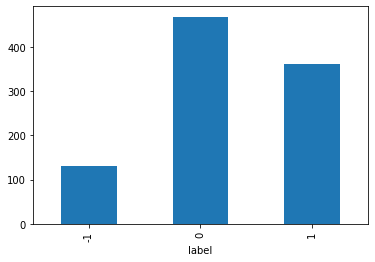

In [ ]:
df_val.groupby(['label']).size().plot.bar()

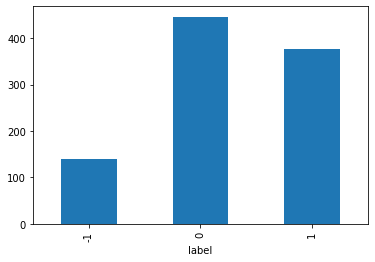

In [ ]:
df_test.groupby(['label']).size().plot.bar()

# **Training**


In [ ]:
# build model:
from torch import nn
from transformers import BertModel

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):
        #Dropout roughly doubles the number of iterations required to converge! #0.5

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)# len(labels)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # _ contains  embedding vectors of all of the tokens in a sequence.
        #  pooled_output has embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

The obtained representations from the BERT tokenizer are input into the BERT model. After several experiments, we found out that the following architecture with (hyper)parameters works best: (final model: on Train data set cleaned with @USER, @LINK, batch size 7)


- final model after: 2 epochs
- learning rate: 1e-5
- dropout rate: 0.1
- adam optimizer (learning_rate= 1e-5, beta1=0.9, beta2=0.999, epsilon=1e-8)


In [ ]:
from torch.optim import Adam
from tqdm import tqdm
import random

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=7, shuffle=True) #2
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=7)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model.to(device)
    criterion = nn.CrossEntropyLoss() #categorical cross entropy because of multi-class classification
    optimizer = Adam(model.parameters(), lr= learning_rate) #lr= learning_rate
    #learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8 https://github.com/torch/optim/blob/master/adam.lua
    #https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #!
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad(): #Disabling gradient calculation: reduce memory consumption for computations that would otherwise  requires grad=True

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            torch.save(model.state_dict(), f'data_volume/final_finetuned_BERT_epoch_{epoch_num}.model')
                  
EPOCHS = 4 #5
model = BertClassifier()
LR = 1e-5 #-6, # hyperparameter: controls how much to change the model in response to the estimated error each time the model weights are updated
set_seed(42)

              
train(model, df_train, df_val, LR, EPOCHS)


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1099/1099 [18:22<00:00,  1.00s/it]


Epochs: 1 | Train Loss:  0.098                 | Train Accuracy:  0.708                 | Val Loss:  0.082                 | Val Accuracy:  0.774


100%|██████████| 1099/1099 [18:22<00:00,  1.00s/it]


Epochs: 2 | Train Loss:  0.060                 | Train Accuracy:  0.865                 | Val Loss:  0.119                 | Val Accuracy:  0.755


100%|██████████| 1099/1099 [18:21<00:00,  1.00s/it]


Epochs: 3 | Train Loss:  0.036                 | Train Accuracy:  0.938                 | Val Loss:  0.172                 | Val Accuracy:  0.748


100%|██████████| 1099/1099 [18:20<00:00,  1.00s/it]


Epochs: 4 | Train Loss:  0.018                 | Train Accuracy:  0.972                 | Val Loss:  0.185                 | Val Accuracy:  0.759


# **Evaluation**

We developed the model and did the tuning/experiments on the training data of the SemEval-2013 edition. Following cells show the evaluation of the epochs of our final model done on our held-out, created test set which we did not use as final evaluation, but complete new/unseen data! Further documentation of experiments done can be found in the appendix of our report. 

In [ ]:
from collections import Counter, defaultdict
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def evaluate(model, test_data):

    test = Dataset(test_data)
    predictions, true_vals = [], []
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    examples = []
    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              
              
              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              Y_ = output.argmax(dim=1)[0].cpu()
              y  = test_label[0].cpu()
              predictions.append(Y_.item()) 
              true_vals.append(y.item()) #numpy()#[0]
              total_acc_test += acc
              if output.argmax(dim=1) != test_label:
                    #print(test_input['input_ids'][0])
                    examples.append((tokenizer.decode(test_input['input_ids'][0][0]).replace("[PAD]","").strip(), y,Y_)) #triple: text, Y, y^
    
    #print(predictions)
    #print(true_vals)

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    recall = recall_score(predictions,true_vals, average='weighted')
    print(f'Recall: {recall: .3f}')
    precision =  precision_score(predictions,true_vals, average='weighted')
    print(f'Precision: { precision: .3f}')
    f1 = f1_score(predictions,true_vals, average='weighted')
    print(f'F1_Score: { f1: .3f}')
    print(f'F2_Score: {(5* precision*recall)/(4*precision+recall):.3f}')
    matrix =multilabel_confusion_matrix(true_vals,predictions, labels=[1,2,0])
    print('Confusion Matrix:')
    print(multilabel_confusion_matrix(true_vals,predictions, labels=[1,2,0]))

    
    # calculate by class Accuracy
    d_acc = defaultdict(lambda: defaultdict(int))
    for pred, true in zip(predictions,true_vals):
      d_acc[true][pred] = d_acc[true][pred] + 1
    #p, v = Counter(p),Counter(v)
    label_dict_inverse = {v: k for k, v in labels.items()}
    for true in d_acc:
      total = sum([d_acc[true][d] for d in d_acc[true]])
      print("\t")
      print("LABEL: " + str(true) + " as " + str(label_dict_inverse[true]))
      print(f'Class Accuracy: {d_acc[true][true] / total: .3f}')

      for otro in d_acc[true]:
        if otro != true:
          print("***assigned as class: "+ str(otro))
          print(f'%: {(d_acc[true][otro] * 100) / total: .3f}')
    
    for ele in examples[:500]:
        print(ele)
#evaluate(model, df_test)
#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device(device)))
evaluate(model, df_test)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.769
Recall:  0.769
Precision:  0.770
F1_Score:  0.768
F2_Score: 0.769
Confusion Matrix:
[[[505  81]
  [ 74 302]]

 [[434  82]
  [114 332]]

 [[763  59]
  [ 34 106]]]
	
LABEL: 2 as neutral
Class Accuracy:  0.744
***assigned as class: 1
%:  15.695
***assigned as class: 0
%:  9.865
	
LABEL: 1 as positive
Class Accuracy:  0.803
***assigned as class: 2
%:  15.691
***assigned as class: 0
%:  3.989
	
LABEL: 0 as negative
Class Accuracy:  0.757
***assigned as class: 2
%:  16.429
***assigned as class: 1
%:  7.857
('[CLS] classy RT @ USER Boehner proposes Obama speech be on the same night as NFL opening night... @ URL [SEP]', tensor(2), tensor(1))
('[CLS] RT @ USER Alright everyone lets do this. 2 winners tonight at 9pmEST. Girl and boy winners. 1600 Microsoft Points. @ USER me and follow fo... [SEP]', tensor(1), tensor(2))
("[CLS] After the disappointment of the 4Draws ( an og bust it ), I've gone for 7 away wins tomorrow ( including the Mersey side derby ). [SEP]", tensor(1),

## **Evaluations done after each epoch:**

In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device(device)))
evaluate(model, df_test)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.767
Recall:  0.767
Precision:  0.768
F1_Score:  0.766
F2_Score: 0.767
Confusion Matrix:
[[[500  86]
  [ 72 304]]

 [[436  80]
  [117 329]]

 [[764  58]
  [ 35 105]]]
	
LABEL: 2 as neutral
Class Accuracy:  0.738
***assigned as class: 1
%:  16.592
***assigned as class: 0
%:  9.641
	
LABEL: 1 as positive
Class Accuracy:  0.809
***assigned as class: 2
%:  15.160
***assigned as class: 0
%:  3.989
	
LABEL: 0 as negative
Class Accuracy:  0.750
***assigned as class: 2
%:  16.429
***assigned as class: 1
%:  8.571


In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('data_volume/final_finetuned_BERT_epoch_2.model', map_location=torch.device(device)))
evaluate(model, df_test)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.771
Recall:  0.771
Precision:  0.779
F1_Score:  0.771
F2_Score: 0.773
Confusion Matrix:
[[[543  43]
  [100 276]]

 [[383 133]
  [ 71 375]]

 [[778  44]
  [ 49  91]]]
	
LABEL: 2 as neutral
Class Accuracy:  0.841
***assigned as class: 1
%:  8.296
***assigned as class: 0
%:  7.623
	
LABEL: 1 as positive
Class Accuracy:  0.734
***assigned as class: 2
%:  23.936
***assigned as class: 0
%:  2.660
	
LABEL: 0 as negative
Class Accuracy:  0.650
***assigned as class: 2
%:  30.714
***assigned as class: 1
%:  4.286


In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('data_volume/final_finetuned_BERT_epoch_3.model', map_location=torch.device(device)))
model.to(device)
evaluate(model, df_test)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.767
Recall:  0.767
Precision:  0.772
F1_Score:  0.768
F2_Score: 0.768
Confusion Matrix:
[[[518  68]
  [ 89 287]]

 [[394 122]
  [ 82 364]]

 [[788  34]
  [ 53  87]]]
	
LABEL: 2 as neutral
Class Accuracy:  0.816
***assigned as class: 1
%:  13.004
***assigned as class: 0
%:  5.381
	
LABEL: 1 as positive
Class Accuracy:  0.763
***assigned as class: 2
%:  21.011
***assigned as class: 0
%:  2.660
	
LABEL: 0 as negative
Class Accuracy:  0.621
***assigned as class: 2
%:  30.714
***assigned as class: 1
%:  7.143


# **Final Evaluation and Results**

Score: (F1_pos+F1_neg)/2 How? 
https://docs.google.com/document/d/1WV-XTvQDpuH_IfKrjzeZ361s1ykcskDNNuOV3oI39_c/edit


Preparing the test data from **SemEval2016**: we did the same processing steps, described above. As the plot displays, the test set is similarly unbalanced (more neutral and positiv esentiments in comparison to the negative ones).

In [ ]:
testpath = '/content/data/twitter-2016test-A.txt'
df = pd.read_csv(testpath, sep='\t', header=None)
df.head()

0  ...    3
0  619950566786113536  ...  NaN
1  619969366986235905  ...  NaN
2  619971047195045888  ...  NaN
3  619974445185302528  ...  NaN
4  619987808317407232  ...  NaN

[5 rows x 4 columns]

In [ ]:
def to_numb(sentiment):
    ''' convert string representation into numeric'''
    if sentiment=="negative":
        return -1
    elif sentiment=="positive":
        return 1
    else:
        return 0

df = pd.DataFrame({"y": df[1], "text": df[2]})
df["label"] = df.y.apply(to_numb)
df['len'] = [len(string) for string in df['text']] # number of characters per tweet
df = df.loc[df["len"] <= 280]

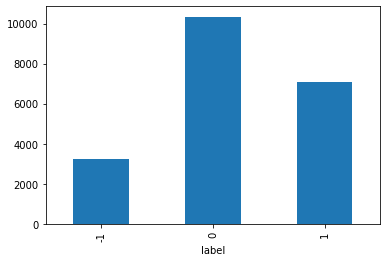

In [ ]:
#twitter-2016test-A.txt:
# equally "unbalanced"
df.groupby(['label']).size().plot.bar()

In [ ]:
text_at_removed = [ re.sub("@[\S]*","@USER", text) for text in df['text']] # \S as any non-whitespace
text_link_removed = [ re.sub("http://[\S]*","@URL", text) for text in text_at_removed]
text_punctuation_sep = [ " ".join(re.findall(r"[\w'@]+|[.,!?;]", string)) for string in text_link_removed]
df['text'] = text_link_removed
df.head()

y                                               text  label  len
0   neutral  Picturehouse's, Pink Floyd's, 'Roger Waters: T...      0  138
1   neutral  Order Go Set a Watchman in store or through ou...      0  140
2  negative  If these runway renovations at the airport pre...     -1  124
3   neutral  If you could ask an onstage interview question...      0   86
4  positive  A portion of book sales from our Harper Lee/Go...      1  140

**Testing on 'twitter-2016test-A.txt':**
Our final model achieved a F1 score of 65% on the test set. In comparison to all other test set evaluation, the model performs here the poorest: ... 

In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device(device)))
evaluate(model, df)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.654
Recall:  0.654
Precision:  0.661
F1_Score:  0.650
F2_Score: 0.656
Confusion Matrix:
[[[11602  1971]
  [ 2304  4755]]

 [[ 7764  2526]
  [ 3919  6423]]

 [[14764  2637]
  [  911  2320]]]
	
LABEL: 2 as neutral
Class Accuracy:  0.621
***assigned as class: 0
%:  21.243
***assigned as class: 1
%:  16.651
	
LABEL: 0 as negative
Class Accuracy:  0.718
***assigned as class: 2
%:  20.489
***assigned as class: 1
%:  7.707
	
LABEL: 1 as positive
Class Accuracy:  0.674
***assigned as class: 2
%:  26.406
***assigned as class: 0
%:  6.233
('[CLS] If these runway renovations at the airport prevent me from seeing Taylor Swift on Monday, Bad Blood will have a new meaning. [SEP]', tensor(0), tensor(2))
("[CLS] Watching Miss USA tomorrow JUST to see @ USER perform, I'm obsessed with his voice [SEP]", tensor(1), tensor(2))
("[CLS] Miss Universe Org prez tells me # Trump won't attend Sunday's Miss USA event He's missed some in the past, but he said recently he'd be here [SEP]", tensor

**Testing on 'semeval-2013-test.csv':**
We did evaluate our model additionally on the unseen test set, provided in the 2013 challenge year. Interestingly, we observed a different distribution of the labels in comparison to that years provided training data (much more positive sentiments!). Nonetheless, our model achieves similar, even slightly better results to the first mock-up tests (F1 score: 0.771 vs 0.768)

In [ ]:
testpath = '/content/data/semeval-2013-test.csv'
df = pd.read_csv(testpath, sep='\t')
df.head()

label                                               text
0      1  I just hope Ian Bennett is first out of the se...
1      1  @JonHeymanCBS What is Selig's next brilliant i...
2      0  When I looked at the full moon last night I im...
3      1  Watched a movie yesterday #The70's on #OVTV an...
4      1  I liked a @YouTube video http://t.co/dSPcjWDB ...

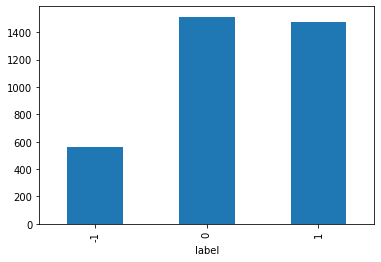

In [ ]:
df['len'] = [len(string) for string in df['text']] # number of characters per tweet
df = df.loc[df["len"] <= 280]
df["y"] = df.label.apply(to_sentiment)
df.groupby(['label']).size().plot.bar()
# different distribution than training set! 

In [ ]:
text_at_removed = [ re.sub("@[\S]*","@USER", text) for text in df['text']] # \S as any non-whitespace
text_link_removed = [ re.sub("http://[\S]*","@URL", text) for text in text_at_removed]
text_punctuation_sep = [ " ".join(re.findall(r"[\w'@]+|[.,!?;]", string)) for string in text_link_removed]
df['text'] = text_link_removed
df.head()

label                                               text  len         y
0      1  I just hope Ian Bennett is first out of the se...  113  positive
1      1  @USER What is Selig's next brilliant idea: Who...  137  positive
2      0  When I looked at the full moon last night I im...   87   neutral
3      1  Watched a movie yesterday #The70's on #OVTV an...  115  positive
4      1  I liked a @USER video @URL THSK - 4th Live Tou...  100  positive

In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device(device)))
evaluate(model, df)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Accuracy:  0.771
Recall:  0.771
Precision:  0.771
F1_Score:  0.771
F2_Score: 0.771
Confusion Matrix:
[[[1788  284]
  [ 333 1140]]

 [[1656  376]
  [ 333 1180]]

 [[2833  153]
  [ 147  412]]]
	
LABEL: 1 as positive
Class Accuracy:  0.774
***assigned as class: 2
%:  18.941
***assigned as class: 0
%:  3.666
	
LABEL: 2 as neutral
Class Accuracy:  0.780
***assigned as class: 1
%:  15.466
***assigned as class: 0
%:  6.543
	
LABEL: 0 as negative
Class Accuracy:  0.737
***assigned as class: 2
%:  17.352
***assigned as class: 1
%:  8.945
("[CLS] I can't believe the first semi - final of Melodifestivalen was just yesterday. Can we press fast - forward to @ USER # TeamDanny [SEP]", tensor(2), tensor(1))
('[CLS] @ USER douglas wack! They got Shumpert 72. He be dunking on niggas. I dunked in Lebron with Lin last night hahahahhaa on Brentley [SEP]', tensor(0), tensor(2))
("[CLS] Passionate about CNIS'work, be a rep at Ten Thousand Villages in your hometown on Mar 8 - Steinbach 355 Main Street [

**selected example tweets: (text, true_label, predicted)**

'@ USER all I can say is that it was very unrealistic. The 1st movie was better - storyline, dialogue! And of course The Grey " thumbs up!', negative, positive)

'How badly I miss Andy Carroll. Knowing that the derby game is tomorrow, he always played very well and scored against blue noses.', positive, negative)


'@ USER Make Sure you tune into @ USER On @ URL tomorrow from 1pm to 3pm, Special Guest Young Savage', positive, neutral)



# **BertViz Model View**

We tried to examine the attention across all of the layers (rows) and heads (columns) in the model. Since we used *bert-base-cased* with its 12 layers and 12 heads and the specific BertTokenizer.from_pretrained('bert-base-cased'), we had to adapt the demo version a bit and of course our input. The attention mechanism was something new for us to work with and is still quite mysterious: It is unclear what kind of information the attention head weights capture; however, it does not resemble human attention intuitively. BERTology research and usage of BERT in many systems has shown its all-rounder nature, probably taking advantage of redundant information encoded and relying on the special characters (see Anna Rogers, Olga Kovaleva, and Anna Rumshisky. 2020. A primer in bertology: What we know about how bert works. http://arxiv.org/abs/2002.12327


Though, the demo gave insights into information used in the model and the quality of the enriched representations. The Bert tokenizer uses bytepair encoding to represent possibly unknown words and reduce the out of vocabulary tokens. The approach is to break down words into sub-words or rather sub-components and piece unknown words together from smaller bits and pieces to obtain a representation. These representation share also attention connection(Layer 2 Head 1)alignments.
Analyzing the model is in comparison to the sentiment classifier with a logistic regression model less transparent and involves more uncertanties. Since this is our first work done with Bert, we believe to have collected enough information to make an informed-model choice with the evaluation, though the attention mechanism and the 110 million parameters is still open to explore.

In [ ]:
!pip install bertviz

     |████████████████████████████████| 156 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 131 kB 49.0 MB/s 
     |████████████████████████████████| 8.5 MB 44.1 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 55.9 MB/s 
     |████████████████████████████████| 127 kB 57.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from bertviz import model_view
from transformers import BertTokenizer, BertModel

In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device(device)))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# Load attention weights
model_version = 'bert-base-cased'
#do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
#tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
CUDA_LAUNCH_BLOCKING = "1"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
        model = model.cuda()

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
sentence_a = "@USER it's girls night! We Go out somewhere to sat and then moomba! Are you like jealous?"
sentence_b = ""
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
#inputs = tokenizer(sentence_a, padding='max_length', max_length = 20, truncation=True, return_tensors='pt', add_special_tokens=True)

token_type_ids = inputs['token_type_ids'].to(device)
input_ids = inputs['input_ids'].squeeze(1).to(device)
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device(device)))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>